In [282]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler

# from keras.models import Sequential
# from keras.layers import Dense, LSTM

In [283]:
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [284]:
stock = "AAPL"

In [285]:
end = datetime.now()
start = datetime(end.year - 10, end.month, end.day)

In [286]:
df = yf.download(stock, start, end)
df = df.reset_index()
df.columns = df.columns.str.lower()
df = df.set_index("date")
df

[*********************100%%**********************]  1 of 1 completed


,open,high,low,close,adj close,volume
date,,,,,,
2014-07-28,24.455000,24.809999,24.387501,24.754999,21.896673,221272000
2014-07-29,24.832500,24.860001,24.562500,24.594999,21.755144,172572000
2014-07-30,24.610001,24.674999,24.417500,24.537500,21.704287,132040000
2014-07-31,24.290001,24.362499,23.832500,23.900000,21.140392,227372000
2014-08-01,23.725000,24.155001,23.702499,24.032499,21.257599,194044000
...,...,...,...,...,...,...
2024-07-22,227.009995,227.779999,223.089996,223.960007,223.960007,48201800
2024-07-23,224.369995,226.940002,222.679993,225.009995,225.009995,39960300
2024-07-24,224.000000,224.800003,217.130005,218.539993,218.539993,61777600


<Axes: xlabel='date', ylabel='close'>

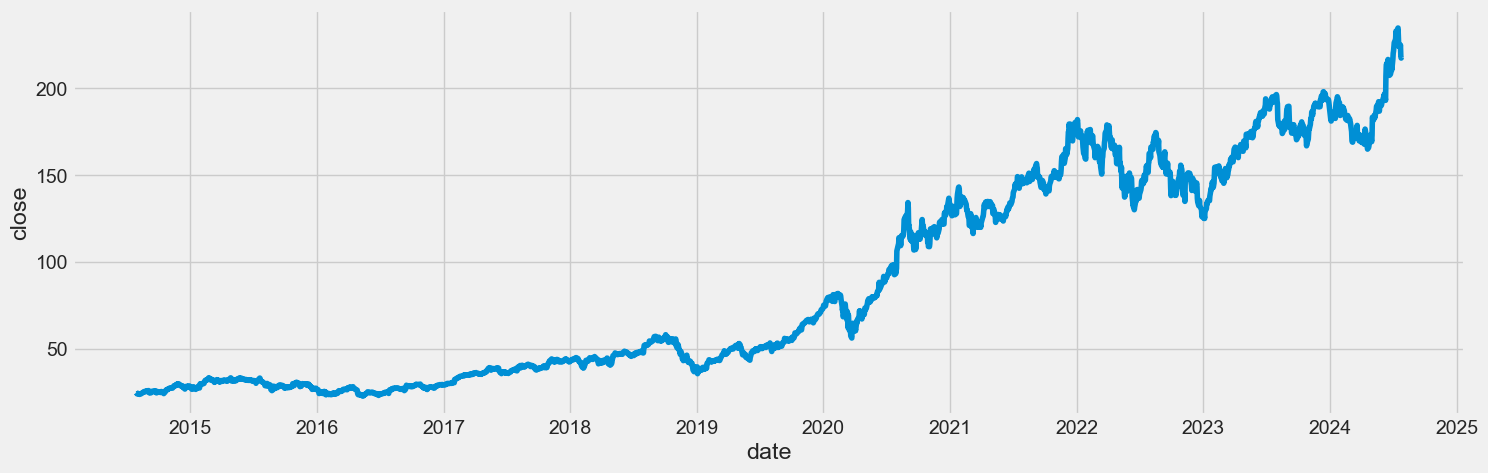

In [287]:
plt.figure(figsize=(16,5))
sns.lineplot(x="date", y="close", data=df)

In [288]:
df

,open,high,low,close,adj close,volume
date,,,,,,
2014-07-28,24.455000,24.809999,24.387501,24.754999,21.896673,221272000
2014-07-29,24.832500,24.860001,24.562500,24.594999,21.755144,172572000
2014-07-30,24.610001,24.674999,24.417500,24.537500,21.704287,132040000
2014-07-31,24.290001,24.362499,23.832500,23.900000,21.140392,227372000
2014-08-01,23.725000,24.155001,23.702499,24.032499,21.257599,194044000
...,...,...,...,...,...,...
2024-07-22,227.009995,227.779999,223.089996,223.960007,223.960007,48201800
2024-07-23,224.369995,226.940002,222.679993,225.009995,225.009995,39960300
2024-07-24,224.000000,224.800003,217.130005,218.539993,218.539993,61777600


In [304]:
def create_lag_features(data, target_column, lag_steps=1):
    if isinstance(lag_steps, int):
        for i in range(1, lag_steps + 1):
            data[f"{target_column}_lag_{i}"] = data[target_column].shift(i)

    if isinstance(lag_steps, list):
        for i in lag_steps:
            data[f"{target_column}_lag_{i}"] = data[target_column].shift(i)

    return data


def create_rolling_mean(data, target_column, window_size=3):
    data[f"{target_column}_rolling_mean"] = data[target_column].rolling(window=window_size).mean()

    return data

def forward_fill_with_decay(df, column, decay_factor):
    """
    Forward fills missing values in a specified column with a decay factor applied.
    
    Parameters:
    - df: The DataFrame containing the data.
    - column: The column name (or index) to apply forward fill with decay.
    - decay_factor: The factor by which the previous value decays (0 < decay_factor < 1).
    
    Returns:
    - The DataFrame with missing values filled with decayed forward fill.
    """
    if not 0 < decay_factor < 1:
        raise ValueError("Decay factor must be between 0 and 1.")
    
    df = df.copy()  # Avoid modifying the original DataFrame
    df[column] = df[column].astype(float)  # Ensure column is of float type for NaNs
    
    # Initialize variables
    last_value = np.nan
    decay = 1.0

    for i in range(len(df)):
        if pd.notna(df.at[i, column]):
            # Update the last value and reset decay
            last_value = df.at[i, column]
            decay = 1.0
            df.at[i, column] = last_value * decay
            decay *= decay_factor  # Apply the decay factor for the next value

        elif pd.isna(df.at[i, column]) and pd.notna(last_value):
            # Apply decay to the last value and fill the current cell
            df.at[i, column] = last_value * decay
            decay *= decay_factor  # Apply the decay factor for the next value
    
    return df


def apply_event(data: pd.DataFrame, event: pd.DataFrame,  falloff: bool = True, decay_factor: float = 0.99) -> pd.DataFrame:
    """Join Events df to data df based on Date"""
    event["date"] = pd.to_datetime(event["date"])

    # Rename Events columns to event_* to avoid conflicts
    for column in event.columns:
        if column != "date":
            event.rename(columns={column: f"event_{column}"}, inplace=True)

    data = data.merge(event, on="date", how="left")

    data["event_decay"] = np.where(pd.notna(data["event_name"]), 1, np.nan)
    data["event_name"] = data["event_name"].ffill()
    data["event_sentiment"] = data["event_sentiment"].ffill()


    # forward fill sentiment with decay
    if falloff:
        data = forward_fill_with_decay(data, "event_decay", decay_factor)

    return data

In [305]:
events_df = pd.DataFrame(data= {'name': ["SPLIT", "ALLTIMEHIGH"], 
                                'date': ["2024-07-17", "2024-07-24"], 
                                'sentiment': [100, 50]})

df1 = apply_event(df.copy(deep=True), events_df, decay_factor=0.98)
df1.tail(10)


,date,open,high,low,close,adj close,volume,event_name,event_sentiment,event_decay
2507,2024-07-15,236.479996,237.229996,233.089996,234.399994,234.399994,62631300,NaN,NaN,NaN
2508,2024-07-16,235.000000,236.270004,232.330002,234.820007,234.820007,43234300,NaN,NaN,NaN
2509,2024-07-17,229.449997,231.460007,226.639999,228.880005,228.880005,57345900,SPLIT,100.0,1.000000
2510,2024-07-18,230.279999,230.440002,222.270004,224.179993,224.179993,66034600,SPLIT,100.0,0.980000
2511,2024-07-19,224.820007,226.800003,223.279999,224.309998,224.309998,49151500,SPLIT,100.0,0.960400
2512,2024-07-22,227.009995,227.779999,223.089996,223.960007,223.960007,48201800,SPLIT,100.0,0.941192
2513,2024-07-23,224.369995,226.940002,222.679993,225.009995,225.009995,39960300,SPLIT,100.0,0.922368
2514,2024-07-24,224.000000,224.800003,217.130005,218.539993,218.539993,61777600,ALLTIMEHIGH,50.0,1.000000
2515,2024-07-25,218.929993,220.850006,214.619995,217.490005,217.490005,51391200,ALLTIMEHIGH,50.0,0.980000
2516,2024-07-26,218.699997,219.490005,216.009995,217.960007,217.960007,41580100,ALLTIMEHIGH,50.0,0.960400


In [279]:
create_lag_features(df1, "open", lag_steps=[1, 2, 4, 8, 16])
# create_rolling_mean(df, "open", window_size=3)

,date,open,high,low,close,adj close,volume,event_name,event_sentiment,open_lag_1,open_lag_2,open_lag_4,open_lag_8,open_lag_16,event_sentiment_lag_1,event_sentiment_lag_2,event_sentiment_lag_4,event_sentiment_lag_8,event_sentiment_lag_16
0,2014-07-28,24.455000,24.809999,24.387501,24.754999,21.896671,221272000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-07-29,24.832500,24.860001,24.562500,24.594999,21.755140,172572000,NaN,NaN,24.455000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-07-30,24.610001,24.674999,24.417500,24.537500,21.704283,132040000,NaN,NaN,24.832500,24.455000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-07-31,24.290001,24.362499,23.832500,23.900000,21.140390,227372000,NaN,NaN,24.610001,24.832500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-08-01,23.725000,24.155001,23.702499,24.032499,21.257593,194044000,NaN,NaN,24.290001,24.610001,24.455000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,2024-07-22,227.009995,227.779999,223.089996,223.960007,223.960007,48201800,SPLIT,0.970299,224.820007,230.279999,235.000000,229.300003,214.690002,0.980100,0.990000,NaN,NaN,NaN
2513,2024-07-23,224.369995,226.940002,222.679993,225.009995,225.009995,39960300,SPLIT,0.960596,227.009995,224.820007,229.449997,231.389999,215.770004,0.970299,0.980100,1.000000,NaN,NaN
2514,2024-07-24,224.000000,224.800003,217.130005,218.539993,218.539993,61777600,ALLTIMEHIGH,1.000000,224.369995,227.009995,230.279999,228.919998,212.089996,0.960596,0.970299,0.990000,NaN,NaN
2515,2024-07-25,218.929993,220.850006,214.619995,217.490005,217.490005,51391200,ALLTIMEHIGH,0.990000,224.000000,224.369995,224.820007,236.479996,216.149994,1.000000,0.960596,0.980100,NaN,NaN


In [322]:
apple= yf.Ticker("aapl")
# apple.actions["Stock Splits"] != 0
# apple.balance_sheet
# apple.dividends
# apple.cashflow
# apple.major_holders
# apple.news
# apple.recommendations
# apple.recommendations_summary
apple.history(period="1y", interval="1h")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-07-27 09:30:00-04:00,196.020004,197.199997,195.820007,195.970001,10214797,0.0,0.0
2023-07-27 10:30:00-04:00,195.979996,196.649902,195.449997,196.139999,5564699,0.0,0.0
2023-07-27 11:30:00-04:00,196.149994,196.440002,195.710007,196.304993,4042621,0.0,0.0
2023-07-27 12:30:00-04:00,196.307999,196.429993,194.960007,195.009995,4224652,0.0,0.0
2023-07-27 13:30:00-04:00,195.000000,195.110199,193.720001,193.729996,5380238,0.0,0.0
...,...,...,...,...,...,...,...
2024-07-26 11:30:00-04:00,217.955002,219.020004,217.509995,218.691193,4508080,0.0,0.0
2024-07-26 12:30:00-04:00,218.710007,219.490005,218.710007,219.304504,3011413,0.0,0.0
2024-07-26 13:30:00-04:00,219.304993,219.326904,217.679993,218.149994,3519375,0.0,0.0


In [122]:

data = df.filter(['Close'])
data

""
date
2014-07-28
2014-07-29
2014-07-30
2014-07-31
2014-08-01
...
2024-07-22
2024-07-23
2024-07-24


In [9]:
# # replace Close with the count of days
# data["Close"] = range(1, len(data) + 1)
# data

In [10]:
dataset = data.values
dataset

array([[ 23.48500061],
       [ 23.68000031],
       [ 24.29750061],
       ...,
       [234.82000732],
       [228.88000488],
       [224.17999268]])

In [11]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data, max(scaled_data), min(scaled_data)

(array([[0.00424059],
        [0.00515938],
        [0.00806889],
        ...,
        [1.        ],
        [0.97201215],
        [0.94986683]]),
 array([1.]),
 array([0.]))

In [ ]:
# How many days to look back
days = 60

x = []
y = []

# Create two arrays, x_train and y_train
# x_train contain arrays of 60 days of data
# y_train contain the 61st day data
for i in range(days, len(scaled_data)):
    x.append(scaled_data[i-days:i, 0])
    y.append(scaled_data[i, 0])

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=42, shuffle=False)


# x_train
# y_train
# x_train[-1], y_train[-2]

In [ ]:
x_test[1], y_test[0]

(array([0.67993024, 0.68619689, 0.69595019, 0.69821189, 0.7132895 ,
        0.73025185, 0.72591697, 0.73807332, 0.75027683, 0.75531837,
        0.75305675, 0.77185661, 0.76431784, 0.77675688, 0.77944255,
        0.78745259, 0.78735834, 0.79565101, 0.79183449, 0.79499136,
        0.78867762, 0.78782947, 0.79070365, 0.78585054, 0.78858337,
        0.79466158, 0.78613323, 0.80493318, 0.79975028, 0.8089382 ,
        0.81572314, 0.80380233, 0.81101138, 0.8263246 , 0.82703133,
        0.82448701, 0.81657122, 0.82151858, 0.81157677, 0.81086996,
        0.80578133, 0.80318985, 0.80366098, 0.80568707, 0.80073971,
        0.7682757 , 0.76172636, 0.75070087, 0.74726123, 0.76789875,
        0.76591982, 0.77086718, 0.7680401 , 0.76959499, 0.7588051 ,
        0.75432887, 0.78236389, 0.7961693 , 0.80714771, 0.81322584]),
 0.8132258434779096)

In [ ]:
x_test[-1], y_test[-1]

(array([0.67498288, 0.67997733, 0.68996631, 0.69406552, 0.6912856 ,
        0.71107496, 0.6961387 , 0.6912856 , 0.70886043, 0.75762716,
        0.74975853, 0.75300958, 0.75461163, 0.76323416, 0.75607227,
        0.77129123, 0.77670972, 0.78749969, 0.78806507, 0.78820642,
        0.79371917, 0.79989163, 0.79305952, 0.77411831, 0.78872472,
        0.78877188, 0.79018535, 0.79489711, 0.79942043, 0.80780735,
        0.80931515, 0.81647697, 0.80992763, 0.82128298, 0.80351963,
        0.86962559, 0.89751926, 0.90303201, 0.89478644, 0.91448155,
        0.90326754, 0.88154633, 0.87122764, 0.87429026, 0.87867223,
        0.89836735, 0.90237237, 0.8859754 , 0.9148585 , 0.93144391,
        0.93747495, 0.96004424, 0.96701769, 0.97106974, 0.99133031,
        0.96583975, 0.97983361, 0.998021  , 1.        , 0.97201215]),
 0.9498668257575196)

In [ ]:
x_test = np.array(x_test)
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
# LSTM expects the input to be 3D
# x_train.shape[0] is the number of samples
# x_train.shape[1] is the number of time steps
# 1 is the number of features

# The reason we need to reshape the data is because LSTM expects the input to be 3D
# In this case, 2332, 60, 1
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# x_train

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=2)

Epoch 1/2


c:\Users\jacob\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2334/2334 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - loss: 0.0022
Epoch 2/2
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - loss: 5.1660e-04


In [ ]:
# Get the models predicted price values 
predictions_scaled = model.predict(x_test)
predictions = scaler.inverse_transform(predictions_scaled)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions_scaled - y_test) ** 2)))
rmse

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


0.11770677388882383

In [ ]:
a = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten().tolist()
b = scaler.inverse_transform(np.reshape(y_test,  (1, len(y_test))))[0].tolist()
pred = scaler.inverse_transform(predictions_scaled).flatten().tolist()
# pred

In [ ]:
rmse = np.sqrt(np.mean(((predictions - b) ** 2)))
rmse

24.98149882547235

In [ ]:
new_table = {'Date': data.iloc[60:, :].index.values,
             'Values': a + b,
             'Prediction': a + pred,
             }

df2 = pd.DataFrame(new_table)

In [ ]:
df2["Date"] = pd.to_datetime(df2["Date"])
df3 = df2.set_index('Date').copy(deep=True)
df3

,Values,Prediction
Date,,
2014-10-13,24.952499,24.952499
2014-10-14,24.687500,24.687500
2014-10-15,24.385000,24.385000
2014-10-16,24.065001,24.065001
2014-10-17,24.417500,24.417500
...,...,...
2024-07-12,230.539993,226.667160
2024-07-15,234.399994,226.589005
2024-07-16,234.820007,228.047134


In [ ]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df3.tail(200)[['Values', 'Prediction']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

NameError: name 'plt' is not defined